In [226]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

In [227]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
a = torch.zeros(4,3)    
a = a.to(device)

In [228]:
labels = {}
#W, R, 1, 2, 3, 4, M 
labels['W']=5
labels['R']=6
labels['M']=0
labels['1']=1
labels['2']=2
labels['3']=3
labels['4']=4

In [229]:
def load_data(dataset):
    batch_size=32
    validation_split = .2
    shuffle_dataset = True
    random_seed= 42
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)


    return train_loader, val_loader

In [230]:

class CustomSleepDataset(Dataset):
    
    def __init__(self, file_list):
        self.x = []
        self.y = []
        for i in file_list.keys():
            self.parse(file_list[i]["PSG.edf"], file_list[i]["Hypnogram.edf"])
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
    def parse(self, sleep, hypnogram):
        _,_, header = highlevel.read_edf(hypnogram)
        signals, _, _ = highlevel.read_edf(sleep)
     
        for annotation in header['annotations']:
            start = int(annotation[0])
            end = int(annotation[1])
            sleep_stage = annotation[2][-1]
            if sleep_stage != '?':
                for i in range(start, end, 30):
                # pick i to i +30 for target range end
                    self.x.append([ signals[0][i*100:(i+30)*100],signals[1][i*100:(i+30)*100], signals[2][i*100:(i+30)*100]])
                    self.y.append(labels[sleep_stage])
    
    def __len__(self):

        return len(self.y)

    
    def __getitem__(self, index):
        
        return (self.x[index], self.y[index])
class CustomSleepSpectrogramDataset(CustomSleepDataset):
    
    def __init__(self, file_list):
        super().__init__(file_list)
    def parse(self, sleep, hypnogram):
        _,_, header = highlevel.read_edf(hypnogram)
        signals, _, _ = highlevel.read_edf(sleep)
        for annotation in header['annotations']:
            start = int(annotation[0])
            end = int(annotation[1])
            sleep_stage = annotation[2][-1]
            if (sleep_stage != '?') and (sleep_stage !='W') and (sleep_stage != 'R') and (sleep_stage != 'e'):
                for i in range(start, start+end, 30):
                # pick i to i +30 for target range end
                    x = np.asarray([ signals[0][i*100:(i+30)*100],signals[1][i*100:(i+30)*100], signals[2][i*100:(i+30)*100]])
                    _,_,x = spectrogram(x, fs=100)
                    self.x.append(x)
                    self.y.append(labels[sleep_stage])



In [231]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [249]:

#filename = '2d_sleeper_dataset.pkl'
filename = '/content/drive/MyDrive/2d_sleeper_dataset.pkl'
infile = open(filename,'rb')
dataset = pickle.load(infile)
dataset.x = (dataset.x - dataset.x.mean())/dataset.x.std()
infile.close()
train_loader, val_loader = load_data(dataset)

In [250]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=7,stride=1,padding=10) 
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=5,stride=2,padding=6)
        self.conv2_drop = nn.Dropout2d()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))   
        #print(x.shape) 
        x = x.view(-1, 128*20*5)  
        return x

class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()

        self.cnn = CNN()
        self.rnn = nn.LSTM(
            input_size=128, 
            hidden_size=64, 
            num_layers=2,
            batch_first=True)
        self.linear = nn.Linear(64,5) 

    def forward(self, x): 
        batch_size, C, H, W = x.size()
        timesteps = 100
        c_in = x.view(batch_size, C, H, W)  
        c_out = self.cnn(c_in)  
        r_in = c_out.view(batch_size, timesteps, -1)  
        r_out, (h_n, h_c) = self.rnn(r_in)  
        r_out2 = self.linear(r_out[:, -1, :])
        return F.log_softmax(r_out2, dim=1)
         

In [251]:
#model = SimpleCNN()
model = Combine()
model.to(device)


Combine(
  (cnn): CNN(
    (conv1): Conv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(10, 10))
    (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
  )
  (rnn): LSTM(128, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=5, bias=True)
)

In [252]:
##load model
import torch.optim as optim
criterion = torch.nn.modules.loss.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [253]:
##train
n_epochs = 35

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):

    model.train()# prep model for training
    # start time
    import time
    start_time = time.time() 

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
            data = data.cuda()
            target = target.cuda()
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, target)
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
           
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        print("--- %s seconds ---" % (time.time() - start_time))
    return model


In [254]:
train_model(model, train_loader,n_epochs, optimizer, criterion)

Epoch 0: curr_epoch_loss=0.7585091590881348
--- 41.63867473602295 seconds ---
Epoch 1: curr_epoch_loss=0.6039285659790039
--- 83.08992290496826 seconds ---
Epoch 2: curr_epoch_loss=0.5768120288848877
--- 124.43184161186218 seconds ---
Epoch 3: curr_epoch_loss=0.5588324666023254
--- 166.00555729866028 seconds ---
Epoch 4: curr_epoch_loss=0.5417046546936035
--- 207.3173942565918 seconds ---
Epoch 5: curr_epoch_loss=0.5295562148094177
--- 248.64177012443542 seconds ---
Epoch 6: curr_epoch_loss=0.5220188498497009
--- 290.0850257873535 seconds ---
Epoch 7: curr_epoch_loss=0.5141026973724365
--- 331.43667793273926 seconds ---
Epoch 8: curr_epoch_loss=0.5028096437454224
--- 372.857314825058 seconds ---
Epoch 9: curr_epoch_loss=0.49732035398483276
--- 414.22553539276123 seconds ---
Epoch 10: curr_epoch_loss=0.4901651442050934
--- 455.5496184825897 seconds ---
Epoch 11: curr_epoch_loss=0.4881790280342102
--- 496.93533635139465 seconds ---
Epoch 12: curr_epoch_loss=0.48163795471191406
--- 538.28

Combine(
  (cnn): CNN(
    (conv1): Conv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(10, 10))
    (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
  )
  (rnn): LSTM(128, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=5, bias=True)
)

In [255]:
def eval_model(model, dataloader):

    model.eval()
    Y_pred = []
    Y_test = []

    import time
    start_time = time.time()  

    for data, target in dataloader:
        data = data.cuda()
        target = target.cuda()
        outputs = model(data)
        _,outputs = torch.max(outputs, dim = 1)
        Y_pred.append(outputs.cpu())

        Y_test.append(target.cpu().detach().numpy())
    print("--- %s seconds ---" % (time.time() - start_time))
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_pred, Y_test

In [256]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

y_pred, y_true = eval_model(model, val_loader) 
acc = accuracy_score(y_true, y_pred) 
print(acc)

f1 = f1_score(y_true, y_pred, average='weighted')
print(f1)

ck = cohen_kappa_score(y_true, y_pred, weights="quadratic")
print(ck)

--- 3.5082600116729736 seconds ---
0.8051041553059222
0.7957894032160864
0.7580495948489501


In [257]:
y_true

array([2, 1, 1, ..., 3, 2, 1])

In [258]:
y_pred

array([2, 2, 2, ..., 2, 2, 1])

In [259]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[1220  861    6    1]
 [ 343 5553   60    2]
 [   0  327  362   27]
 [   0    9  151  247]]


In [260]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=False,
                          percent=True,
                          cbar=True,
                          xyticks=True, 
                          figsize=None,
                          cmap='Blues',
                          title=None):  
   
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
 
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="", 
                linewidths=.2,  
                linecolor="black", 
                 
                cmap=cmap,cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
  
    plt.ylabel('True label - Sleep Stages')
    plt.xlabel('Predicted label - Sleep Stages') 
    
    if title:
        plt.title(title)    

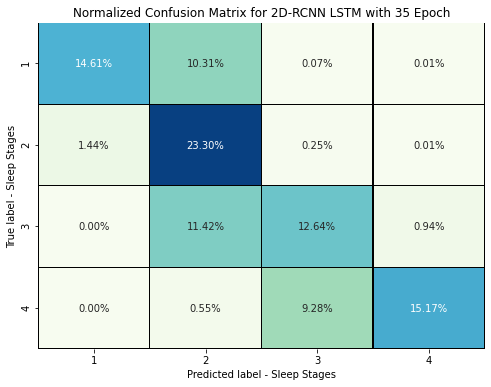

In [261]:
title = "Normalized Confusion Matrix for 2D-RCNN LSTM with 35 Epoch" 
categories = [1,2,3,4]
# Normalize #
conf_mat_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
create_confusion_matrix(conf_mat_normalized, figsize=(8,6), count=False, cbar=False, title=title,
                      categories = categories, cmap="GnBu")